In [48]:
import hist
import boost_histogram as bh
import numpy as np
import mplhep as hep
import matplotlib.pyplot as plt
from utilities import boostHistHelpers as hh
from wremnants import histselections as sel
from wremnants import datasets2016
from wremnants import plot_tools
import wremnants
import lz4.frame
import pickle
import uproot
hep.style.use(hep.style.ROOT)

sh: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
sh: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
sh: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
sh: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
sh: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
sh: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
sh: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
sh: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


Welcome to JupyROOT 6.26/06


2023-02-09 14:59:40.120320: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-09 14:59:40.472616: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /.singularity.d/libs
2023-02-09 14:59:40.472646: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-09 14:59:40.501274: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-09 14:59:41.279442: W

In [49]:
with lz4.frame.open("../mw_with_mu_eta_pt.pkl.lz4") as f:
    boost = pickle.load(f)

In [50]:
print(boost['WplusmunuPostVFP']['event_count'])
print(boost['dataPostVFP']['event_count'])

286427993.0
326723487.0


In [51]:
wp = boost['WplusmunuPostVFP']['output']
wm = boost['WminusmunuPostVFP']['output']
print(wp.keys())

dict_keys(['MET_uncorr_pt', 'MET_uncorr_phi', 'METx_uncorr', 'METy_uncorr', 'MET_corr_lep_pt', 'MET_corr_lep_phi', 'METx_corr_lep', 'METy_corr_lep', 'MET_corr_xy_pt', 'MET_corr_xy_phi', 'METx_corr_xy', 'METy_corr_xy', 'METx_corr_lep_npv', 'METy_corr_lep_npv', 'METx_corr_xy_npv', 'METy_corr_xy_npv', 'recoil_corr_xy_magn_gen', 'recoil_corr_xy_para_gen', 'recoil_corr_xy_para_qT_gen', 'recoil_corr_xy_perp_gen', 'recoil_corr_xy_para_qT_perp_gen', 'recoil_corr_xy_magn_qTbinned_gen', 'recoil_corr_xy_para_qTbinned_gen', 'recoil_corr_xy_para_qT_qTbinned_gen', 'recoil_corr_xy_perp_qTbinned_gen', 'qT_gen', 'mTStudyForFakes', 'nominal_weight', 'nominal', 'nominal_gen', 'nominal_gen_smeared', 'nominal_qcdJetPt45', 'nominal_effStatTnP_sf_reco', 'nominal_effStatTnP_sf_tracking', 'nominal_effStatTnP_sf_idip', 'nominal_effStatTnP_sf_trigger', 'nominal_effStatTnP_sf_iso_effData', 'nominal_effStatTnP_sf_iso_effMC', 'nominal_effSystTnP', 'nominal_muonL1PrefireStat', 'nominal_muonL1PrefireSyst', 'nominal_e

/home/t/tyjyang/analysis/wmass/WRemnants/utilities/boostHistHelpers.py:68: RuntimeWarning: invalid value encountered in divide
  np.divide(hvars, hvals*hvals, out=out, where=nonzero),
/home/t/tyjyang/analysis/wmass/WRemnants/utilities/boostHistHelpers.py:68: RuntimeWarning: invalid value encountered in divide
  np.divide(hvars, hvals*hvals, out=out, where=nonzero),
/home/t/tyjyang/analysis/wmass/WRemnants/utilities/boostHistHelpers.py:68: RuntimeWarning: invalid value encountered in divide
  np.divide(hvars, hvals*hvals, out=out, where=nonzero),
/home/t/tyjyang/analysis/wmass/WRemnants/utilities/boostHistHelpers.py:68: RuntimeWarning: invalid value encountered in divide
  np.divide(hvars, hvals*hvals, out=out, where=nonzero),
/home/t/tyjyang/analysis/wmass/WRemnants/utilities/boostHistHelpers.py:68: RuntimeWarning: invalid value encountered in divide
  np.divide(hvars, hvals*hvals, out=out, where=nonzero),
/home/t/tyjyang/analysis/wmass/WRemnants/utilities/boostHistHelpers.py:68: Runti

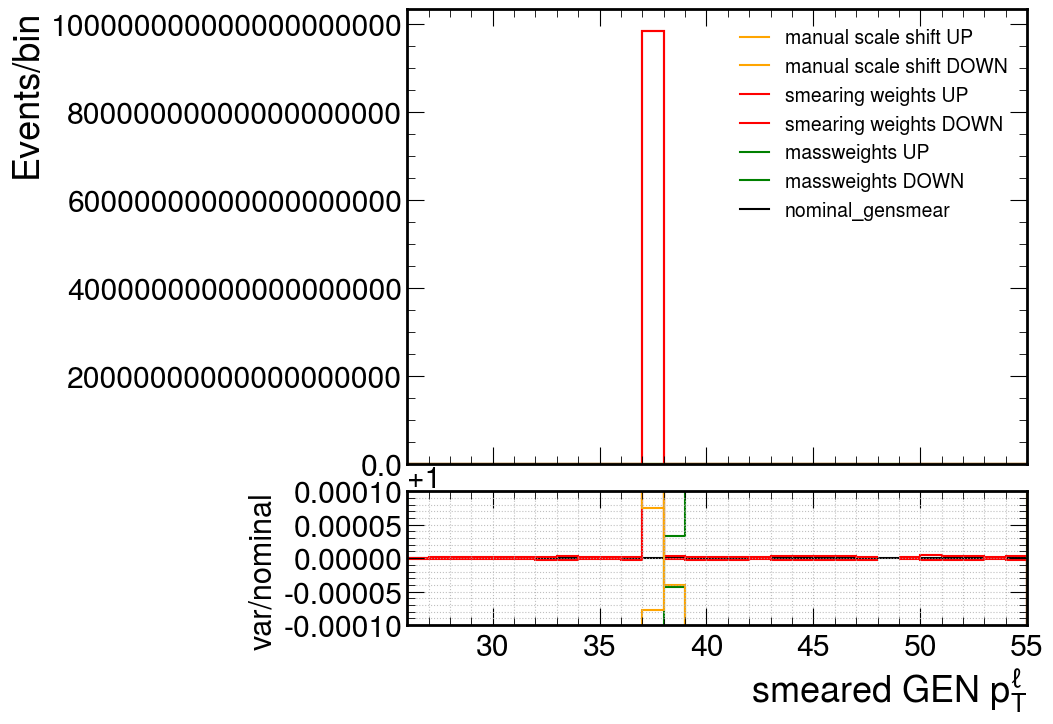

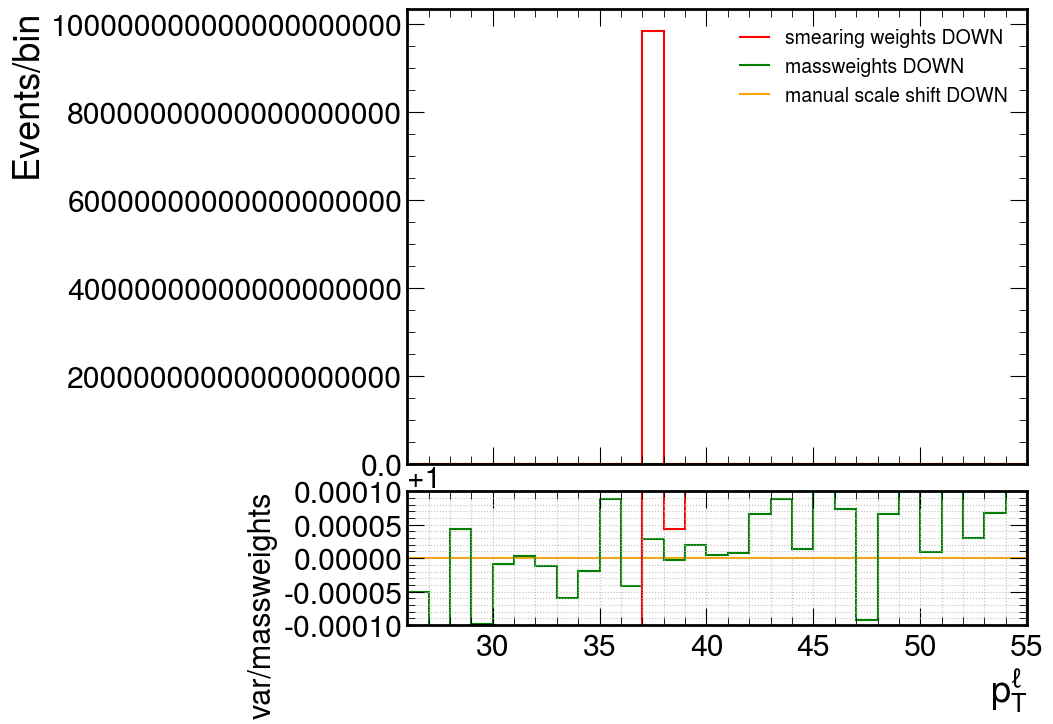

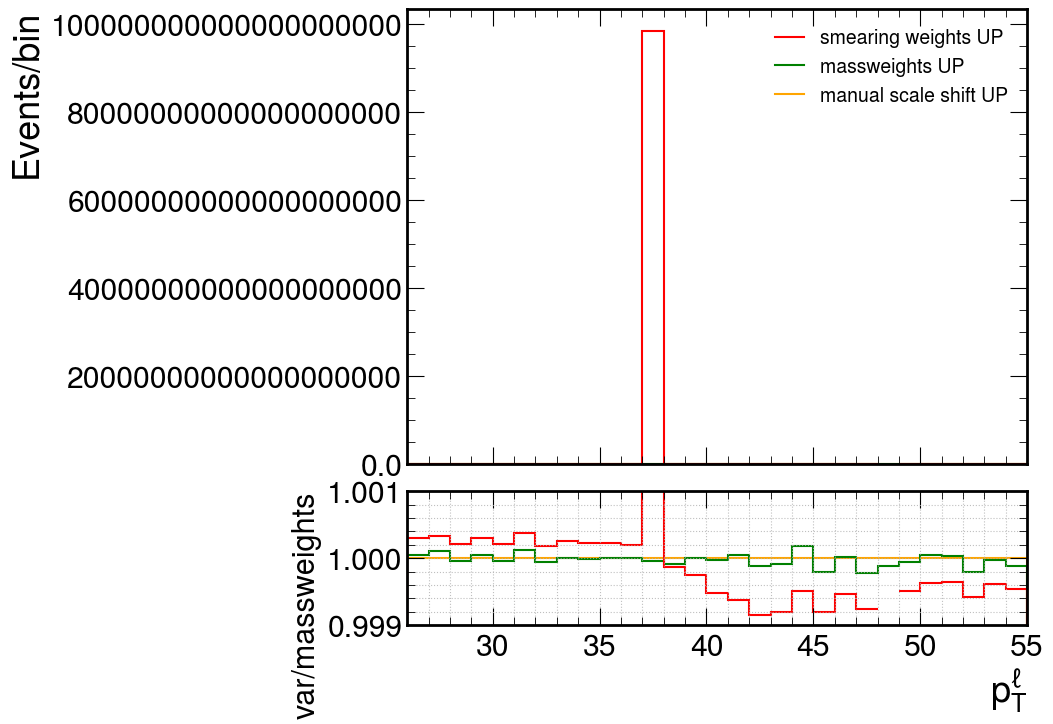

In [52]:
action = lambda x: x.project('pt')
#action = lambda x: sel.unrolledHist(x)

nominal_gensmear = action(wp['nominal_gen_smeared'][{'charge':1j}])
ms_from_massweights = [action(wp['nominal_muonScaleSyst_gen_smear'][{'charge':1j}][...,0,0]), 
                       action(wp['nominal_muonScaleSyst_gen_smear'][{'charge':1j}][...,1,0])]
ms_from_smearing = [action(wp['muonScaleSyst_responseWeights_gensmear'][{'charge':1j}][...,143,0]), 
                    action(wp['muonScaleSyst_responseWeights_gensmear'][{'charge':1j}][...,143,1])]
ms_from_scale_var = [action(wp['nominal_muonScaleVariationDnTenthmil_gen_smear'][{'charge':1j}]),
                     action(wp['nominal_muonScaleVariationUpTenthmil_gen_smear'][{'charge':1j}])]
fig = plot_tools.makePlotWithRatioToRef(
    [
        nominal_gensmear,
        ms_from_massweights[0],
        ms_from_massweights[1],
        ms_from_smearing[0],
        ms_from_smearing[1],
        ms_from_scale_var[0],
        ms_from_scale_var[1]#* nominal.sum().value / ms_from_scale_var.sum().value
    ],
    labels = [
        'nominal_gensmear', 
        'massweights DOWN',
        'massweights UP',
        'smearing weights DOWN',
        'smearing weights UP',
        'manual scale shift DOWN',
        'manual scale shift UP'
    ],
    colors = ['black', 'green', 'green', 'red', 'red', 'orange', 'orange'],
    rrange = [0.9999, 1.0001],
    nlegcols = 1,
    rlabel = 'var/nominal',
    xlabel = r'smeared GEN $p_T^{\ell}$',
    grid = True
)


fig = plot_tools.makePlotWithRatioToRef(
    [
        ms_from_scale_var[0],
        ms_from_massweights[0],
        ms_from_smearing[0] #* ms_from_massweights[0].sum().value/ ms_from_smearing[0].sum().value,
        
    ],
    labels = [ 
        'manual scale shift DOWN',
        'massweights DOWN',
        'smearing weights DOWN'
        
    ],
    colors = ['orange','green', 'red'],
    rrange = [0.9999, 1.0001],
    nlegcols = 1,
    rlabel = 'var/massweights',
    xlabel = r'$p_T^{\ell}$',
    grid = True
)

fig = plot_tools.makePlotWithRatioToRef(
    [
        ms_from_scale_var[1],
        ms_from_massweights[1],
        ms_from_smearing[1] #* ms_from_massweights[0].sum().value/ ms_from_smearing[0].sum().value,
        
    ],
    labels = [ 
        'manual scale shift UP',
        'massweights UP',
        'smearing weights UP'
        
    ],
    colors = ['orange','green', 'red'],
    rrange = [0.999, 1.001],
    nlegcols = 1,
    rlabel = 'var/massweights',
    xlabel = r'$p_T^{\ell}$',
    grid = True
)

In [53]:
ms_from_smearing[0].values()

array([2.61793850e+06, 2.82097935e+06, 3.01099692e+06, 3.19330681e+06,
       3.37522365e+06, 3.54979789e+06, 3.72977963e+06, 3.90201273e+06,
       4.06979311e+06, 4.22597349e+06, 4.35094241e+06, 9.85321501e+19,
       4.32409026e+06, 4.04517273e+06, 3.57059255e+06, 2.98863486e+06,
       2.44117047e+06, 1.98991932e+06, 1.64026919e+06, 1.37434589e+06,
       1.17036132e+06, 1.00632071e+06,            inf, 7.73335608e+05,
       6.84140002e+05, 6.10874827e+05, 5.47740810e+05, 4.94315860e+05,
       4.46300572e+05])

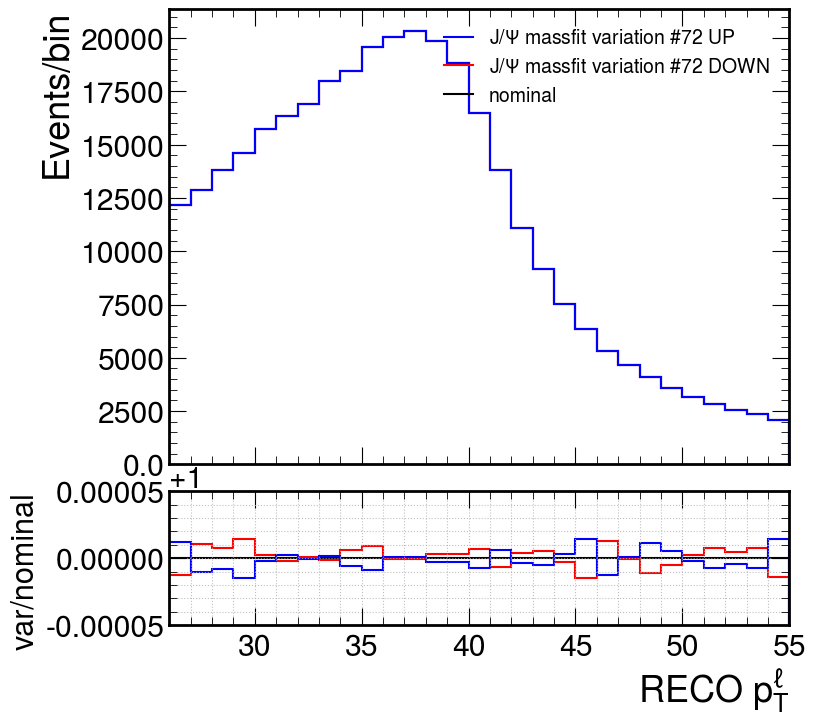

In [47]:
action = lambda x: x.project('pt')
#action = lambda x: sel.unrolledHist(x)

nominal = action(wp['nominal'][{'charge':1j}])
ms_from_smearing = [action(wp['nominal_muonScaleSyst_responseWeights'][{'charge':1j}][...,143,0]), 
                    action(wp['nominal_muonScaleSyst_responseWeights'][{'charge':1j}][...,143,1])]


fig = plot_tools.makePlotWithRatioToRef(
    [
        nominal,
        ms_from_smearing[0],
        ms_from_smearing[1]
    ],
    labels = [
        'nominal', 
        r'J/$\Psi$ massfit variation #72 DOWN',
        r'J/$\Psi$ massfit variation #72 UP',
    ],
    colors = ['black', 'red', 'blue'],
    rrange = [0.99995, 1.00005],
    nlegcols = 1,
    rlabel = 'var/nominal',
    xlabel = r'RECO $p_T^{\ell}$',
    grid = True
)

In [6]:
import uproot
import hist
import numpy as np
from wremnants import muon_validation

n_scale_params = 3
n_tot_params = 4
n_eta_bins = 24
filepath = "../wremnants/data/calibration/calibrationJDATA_smeared_v718.root"

f = uproot.open(filepath)
cov = f['covariance_matrix'].to_hist()
cov_scale_params = muon_validation.get_jpsi_scale_param_cov_mat(cov, n_scale_params, n_tot_params, n_eta_bins)

w,v = np.linalg.eigh(cov_scale_params)
var_mat = np.sqrt(w) * v
axis_eta = hist.axis.Regular(n_eta_bins, -2.4, 2.4, name = 'eta')
axis_scale_params = hist.axis.Regular(n_scale_params, 0, 1, name = 'scale_params')
axis_scale_params_unc = hist.axis.Regular(
    n_eta_bins * n_scale_params, 0, n_eta_bins * n_scale_params,
    underflow = False, overflow = False,  name = 'unc'
)
hist_scale_params_unc = hist.Hist(axis_eta, axis_scale_params, axis_scale_params_unc)
for i in range(n_eta_bins):
    lb, ub = i * n_scale_params, (i + 1) * n_scale_params
    hist_scale_params_unc.view()[i,...] = var_mat[lb:ub][:]



In [7]:
print(f.keys())
f['correlation_matrix'].values()
cov.values().diagonal()

['A;1', 'e;1', 'M;1', 'a;1', 'correlation_matrix;1', 'covariance_matrix;1', 'scaleBinned;1', 'sigmaBinned;1']


array([8.29950352e-09, 3.40708877e-07, 2.03880541e-11, 3.47066682e-12,
       3.52737816e-09, 1.54499322e-07, 9.29301927e-12, 1.10610170e-12,
       1.93686356e-09, 8.76799012e-08, 5.11013243e-12, 4.55614693e-13,
       1.29316316e-09, 6.07797432e-08, 3.33506871e-12, 2.50319554e-13,
       8.36630760e-10, 3.46400580e-08, 2.40554420e-12, 1.33160889e-13,
       6.86471086e-10, 2.75496413e-08, 1.93917746e-12, 9.45786811e-14,
       5.86147149e-10, 2.51786994e-08, 1.52089433e-12, 6.47788169e-14,
       4.10151765e-10, 1.72755588e-08, 1.13422414e-12, 2.98982172e-14,
       2.86356747e-10, 1.26720999e-08, 8.74587326e-13, 1.58496192e-14,
       2.52887736e-10, 1.13228169e-08, 7.54585966e-13, 1.12889319e-14,
       2.66545341e-10, 1.29878898e-08, 6.85758615e-13, 1.01725554e-14,
       2.03199459e-10, 1.00399359e-08, 5.94767664e-13, 5.41213044e-15,
       2.07544790e-10, 1.02351334e-08, 6.03416728e-13, 5.58462324e-15,
       2.83024238e-10, 1.37949420e-08, 7.11905477e-13, 1.07507454e-14,
      

In [8]:
wp['nominal_muonScaleSyst_responseWeights']

Hist(
  Regular(48, -2.4, 2.4, name='eta'),
  Regular(29, 26, 55, name='pt'),
  Regular(2, -2, 2, underflow=False, overflow=False, name='charge'),
  Boolean(name='passIso'),
  Boolean(name='passMT'),
  Regular(72, 0, 1, underflow=False, overflow=False, name='unc'),
  Regular(2, -2, 2, underflow=False, overflow=False, name='downUpVar'),
  storage=Weight()) # Sum: WeightedSum(value=1.04064e+10, variance=3.95344e+10) (WeightedSum(value=1.19865e+10, variance=4.51512e+10) with flow)

In [ ]:
hep.hist2dplot(cov)

In [ ]:
hep.hist2dplot(hist_scale_params_unc[{'scale_params':0}])

In [ ]:
hep.hist2dplot(hist_scale_params_unc[{'scale_params':1}])

In [ ]:
hep.hist2dplot(hist_scale_params_unc[{'scale_params':2}])

In [23]:
f = uproot.open('../wremnants/data/calibration/calibrationJDATA_smeared_v718.root')

#print("cov mat of A, e, M, res in eta bins", f['covariance_matrix'].values())
A_uncs = []
e_uncs = []
M_uncs = []
As = f['A'].values()
es = f['e'].values()
Ms = f['M'].values()
for i in range(24):
    A_uncs.append(cov_scale_params.diagonal()[3*i])
    e_uncs.append(cov_scale_params.diagonal()[3*i+1])
    M_uncs.append(cov_scale_params.diagonal()[3*i+2])
print("uncs on A: \n")
for A_unc, A in zip(A_uncs,As): print(np.sqrt(A_unc))
print('\n')
print("uncs on e: \n")
for e_unc, e in zip(e_uncs, es): print(np.sqrt(e_unc))
print('\n')
print("uncs on M: \n")
for M_unc, M in zip(M_uncs, Ms): print(np.sqrt(M_unc))

uncs on A: 

9.110161098869564e-05
5.939173474792539e-05
4.4009812097600475e-05
3.596057780322258e-05
2.8924570186368128e-05
2.6200593228764187e-05
2.421047601240071e-05
2.0252203963706383e-05
1.6922078688607735e-05
1.5902444330109298e-05
1.632621638538772e-05
1.4254804755813083e-05
1.4406414884297477e-05
1.6823324232144634e-05
1.622175764374823e-05
1.72457638447175e-05
2.070403721483647e-05
2.4465032027597626e-05
2.6301781072784458e-05
2.8758010771441913e-05
3.513476557860456e-05
4.294021358948935e-05
5.736353038872373e-05
8.898409405123758e-05


uncs on e: 

0.0005837027296619956
0.00039306401769743243
0.00029610792151996823
0.0002465354806269808
0.000186118397769573
0.00016598084632399624
0.00015867797399691142
0.00013143651994072464
0.00011257042182843178
0.00010640872556454348
0.00011396442325177886
0.00010019948031398103
0.0001011688362179802
0.00011745187116548933
0.00010856056219061142
0.00011499344424722382
0.00013438351762521728
0.00016026124889643203
0.0001664037727473665
0.

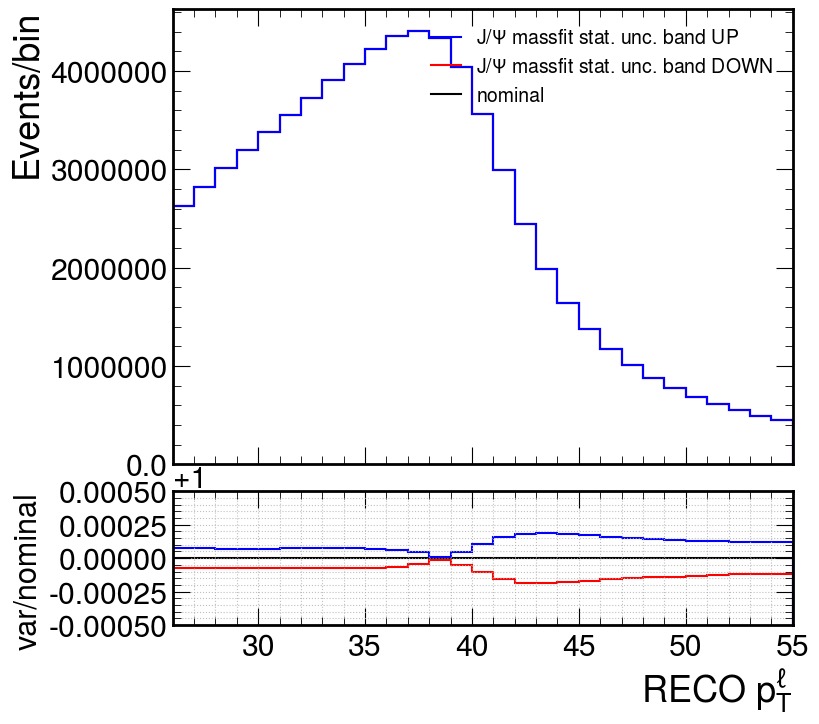

In [22]:
swv = wp['nominal_muonScaleSyst_responseWeights']

for i in range(swv[0,0,0,0,0,...,0].size):
    var_h_dn = hh.addHists(swv[{'charge':1j, 'downUpVar':0, 'unc':i}].project('pt'), -1 * nominal)
    var_h_up = hh.addHists(swv[{'charge':1j, 'downUpVar':1, 'unc':i}].project('pt'), -1 * nominal)
    varsqd_h_dn = hh.multiplyHists(var_h_dn, var_h_dn)
    varsqd_h_up = hh.multiplyHists(var_h_up, var_h_up)
    #print('varsqd dn/up in bin 16 is:',  varsqd_h_dn[15].value/varsqd_h_up[15].value, 'in variable #', i)
    if i == 0:
        tot_varsqd_h_dn = varsqd_h_dn 
        tot_varsqd_h_up = varsqd_h_up
    else: 
        tot_varsqd_h_dn = hh.addHists(tot_varsqd_h_dn, varsqd_h_dn)
        tot_varsqd_h_up = hh.addHists(tot_varsqd_h_up, varsqd_h_up)
tot_var_h_dn = hh.sqrtHist(tot_varsqd_h_dn)
tot_var_h_up = hh.sqrtHist(tot_varsqd_h_up)

h_dn = hh.addHists(nominal, -1 * tot_var_h_dn)
h_up = hh.addHists(nominal, tot_var_h_up)

fig = plot_tools.makePlotWithRatioToRef(
    [
        nominal,
        h_dn,
        h_up
    ],
    labels = [
        'nominal', 
        r'$J/\Psi$ massfit stat. unc. band DOWN',
        r'$J/\Psi$ massfit stat. unc. band UP',
    ],
    colors = ['black','red', 'blue'],
    rrange = [0.9995, 1.0005],
    nlegcols = 1,
    rlabel = 'var/nominal',
    xlabel = r'RECO $p_T^{\ell}$',
    grid = True
)    

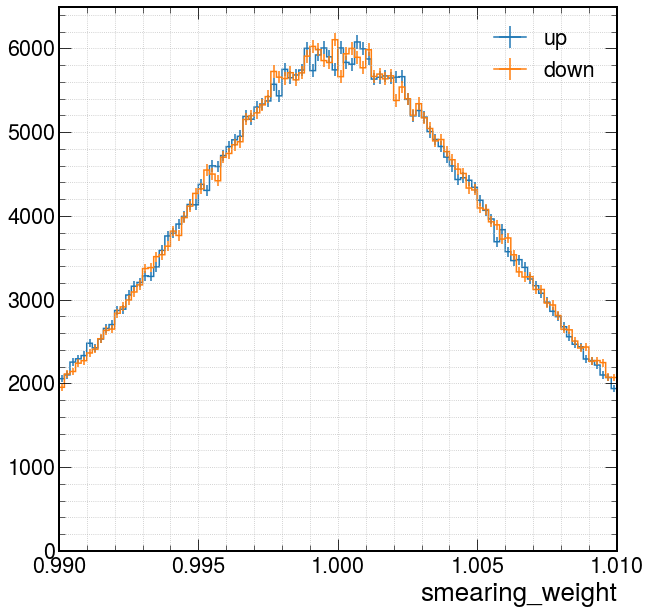

In [27]:
fig, ax = plt.subplots()
hep.histplot(wp['smearing_weights_up'].project('smearing_weight'), label = "up", ax=ax)
hep.histplot(wp['smearing_weights_down'].project('smearing_weight'), label = "down", ax=ax)
ax.legend()
ax.set_xlim(0.99,1.01)
ax.grid(which='both')

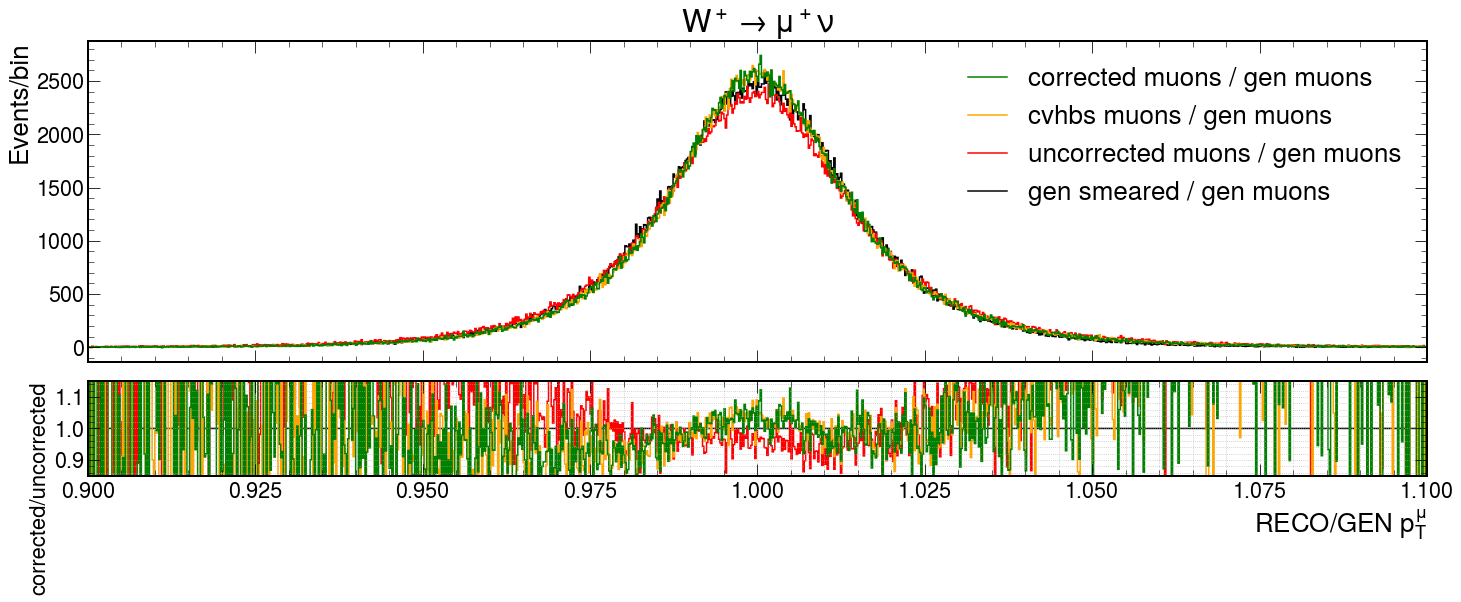

In [28]:
wp_label = r'$W^+ \rightarrow \mu^+ \nu$' 
fig = plot_tools.makePlotWithRatioToRef(
    [
        wp['gen_smeared_over_gen'].project('reco_pt_over_gen'),
        wp['uncrct_over_gen'].project('reco_pt_over_gen'),
        wp['cvhbs_over_gen'].project('reco_pt_over_gen'),
        wp['crctd_over_gen'].project('reco_pt_over_gen')
    ],
    labels = [ 
        'gen smeared / gen muons',
        'uncorrected muons / gen muons',
        'cvhbs muons / gen muons',
        'corrected muons / gen muons'
    ],
    colors = ['black','red', 'orange', 'green'],
    rrange = [0.85, 1.15],
    nlegcols = 1,
    rlabel = 'corrected/uncorrected',
    xlabel = r'RECO/GEN $p_T^{\mu}$',
    #xlim = [0.9995, 1.0005],
    grid = True,
    bin_density = 400,
    x_ticks_ndp = 3,
    plot_title = wp_label
)

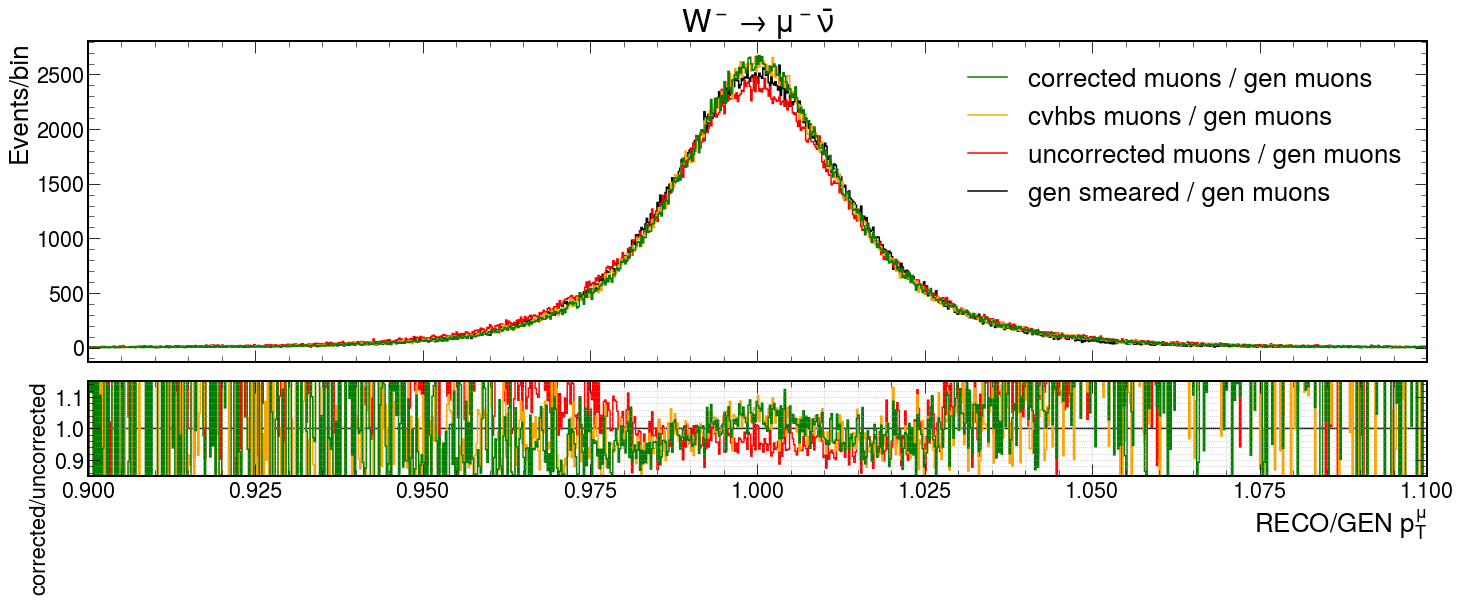

In [29]:
wm_label = r'$W^- \rightarrow \mu^- \bar{\nu}$' 
fig = plot_tools.makePlotWithRatioToRef(
    [
        wm['gen_smeared_over_gen'].project('reco_pt_over_gen'),
        wm['uncrct_over_gen'].project('reco_pt_over_gen'),
        wm['cvhbs_over_gen'].project('reco_pt_over_gen'),
        wm['crctd_over_gen'].project('reco_pt_over_gen')
    ],
    labels = [ 
        'gen smeared / gen muons',
        'uncorrected muons / gen muons',
        'cvhbs muons / gen muons',
        'corrected muons / gen muons'
    ],
    colors = ['black','red', 'orange', 'green'],
    rrange = [0.85, 1.15],
    nlegcols = 1,
    rlabel = 'corrected/uncorrected',
    xlabel = r'RECO/GEN $p_T^{\mu}$',
    #xlim = [0.9995, 1.0005],
    grid = True,
    bin_density = 400,
    x_ticks_ndp = 3,
    plot_title = wm_label
)

Hist(
  Regular(29, 26, 55, name='pt', label='pt'),
  Regular(48, -2.4, 2.4, name='eta', label='eta'),
  storage=Weight()) # Sum: WeightedSum(value=398568, variance=491711) (WeightedSum(value=459008, variance=561876) with flow)


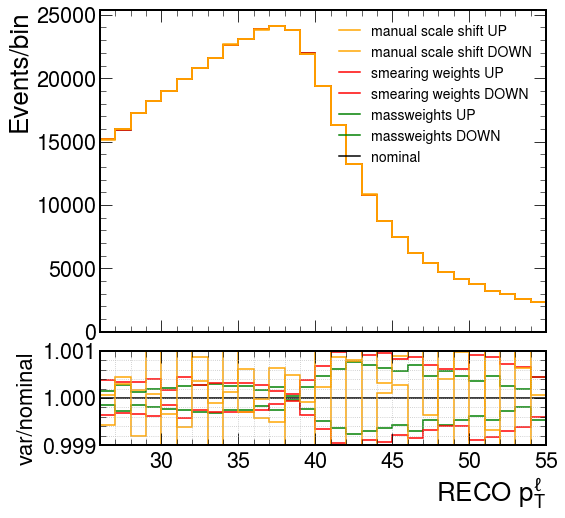

In [30]:
nominal_gen_smearing = wp['nominal_gen_smeared'][{'charge':1j}].project('pt', 'eta')
print(nominal_gen_smearing)

gen_smeared_msv_from_sw = [wp['muonScaleSyst_responseWeights_gensmear'][{'charge':1j}][...,0,0].project('pt', 'eta'), 
                           wp['muonScaleSyst_responseWeights_gensmear'][{'charge':1j}][...,0,1].project('pt', 'eta')]
smearing_weights_per_bin_up = hh.divideHists(gen_smeared_msv_from_sw[0], nominal_gen_smearing)
smearing_weights_per_bin_dn = hh.divideHists(gen_smeared_msv_from_sw[1], nominal_gen_smearing)

nominal_reco = wp['nominal'][{'charge':1j}].project('pt', 'eta')
msv_reco_massweights = [wp['muonScaleSyst'][{'charge':1j}][...,0,0].project('pt', 'eta'), 
                        wp['muonScaleSyst'][{'charge':1j}][...,1,0].project('pt', 'eta')]
msv_reco_manual = [wp['muonScaleVariationDnTenthmil'][{'charge':1j}].project('pt', 'eta'), 
                   wp['muonScaleVariationUpTenthmil'][{'charge':1j}].project('pt', 'eta')]
#msv_reco_sw = [hh.multiplyHists(nominal_reco, smearing_weights_per_bin_dn),
#               hh.multiplyHists(nominal_reco, smearing_weights_per_bin_up)]

msv_reco_sw = [wp['muonScaleSyst_responseWeights'][...,0], wp['muonScaleSyst_responseWeights'][...,1]]
fig = plot_tools.makePlotWithRatioToRef(
    [
        action(nominal_reco),
        action(msv_reco_massweights[0]),
        action(msv_reco_massweights[1]),
        action(msv_reco_sw[0]),
        action(msv_reco_sw[1]),
        action(msv_reco_manual[0]),
        action(msv_reco_manual[1])#* nominal.sum().value / ms_from_scale_var.sum().value
    ],
    labels = [
        'nominal', 
        'massweights DOWN',
        'massweights UP',
        'smearing weights DOWN',
        'smearing weights UP',
        'manual scale shift DOWN',
        'manual scale shift UP'
    ],
    colors = ['black', 'green', 'green', 'red','red', 'orange', 'orange'],
    rrange = [0.999, 1.001],
    nlegcols = 1,
    rlabel = 'var/nominal',
    xlabel = r'RECO $p_T^{\ell}$',
    grid = True
)

In [31]:
proj_axes = ['pt', 'eta']
a = wp['muonScaleSyst_gen_smear'].project(*proj_axes)
print(a.axes)
a.project('pt')
#print(wp['muonScaleSyst_gen_smear'][{'pt':hist.loc(26)}].project('pt'))

(Regular(29, 26, 55, name='pt', label='pt'), Regular(48, -2.4, 2.4, name='eta', label='eta'))


Hist(Regular(29, 26, 55, name='pt', label='pt'), storage=Weight()) # Sum: WeightedSum(value=797188, variance=983518) (WeightedSum(value=918011, variance=1.12377e+06) with flow)

In [32]:
proc = 'WplusmunuPostVFP'
print(any([x in proc for x in ['mlus', 'Plus']]))

False


In [33]:
wp['muonScaleSyst_responseWeights']

Hist(
  Regular(29, 26, 55, name='pt', label='pt'),
  Regular(48, -2.4, 2.4, name='eta', label='eta'),
  Regular(2, -2, 2, underflow=False, overflow=False, name='downUpVar', label='downUpVar'),
  storage=Weight()) # Sum: WeightedSum(value=797499, variance=2.96158e+06) (WeightedSum(value=918025, variance=3.38078e+06) with flow)